In [16]:
import logging
import pprint

import tensorflow as tf
import keras as keras
import sklearn.model_selection
import sklearn.datasets
import numpy as np
import typing
import matplotlib.pyplot as plt



In [17]:
import logging
logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

log.debug("testing debug")

DEBUG:__main__:testing debug


# Setup

## Globals

In [18]:
default_params = {
  "optimizer" : "SGD",
  "batch_size" : 64,
}

## Data

In [19]:
X_mc,y_mc = sklearn.datasets.make_classification(
  n_samples=10000,
  n_features=10,
  n_redundant=2,
  n_classes=3,
  n_clusters_per_class=1,
  class_sep=0.5
)

X_train_mc, X_test_mc, y_train_mc, y_test_mc = sklearn.model_selection.train_test_split(
  X_mc,
  y_mc,
  test_size=0.33,
  random_state=42
)

## Functions

In [20]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
  """
  Plots the training history of multiple models on the same plot for comparison.
  
  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]
  
  # Initialize the plot
  plt.figure(figsize=(10, 6))

  norm = plt.Normalize(vmin=0, vmax=len(histories))
  grayscale_cmap = plt.colormaps['gray']
  
  sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
  
  log.debug(f"sorted_keys: {sorted_keys}")
  log.debug(f"accuracies: {[ sort_agg_func(histories[k].history[metric][:-sort_history_length]) for k in sorted_keys]}")
  
  for i, label in enumerate(sorted_keys):
    history = histories[label]
    #for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)
    
    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))
    
    # Plot validation metric if available
    if show_validation and f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))
  
  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()
  
  # Show plot
  plt.show()


In [21]:
def get_model(
        num_input_features=4, 
        activation_function="elu", 
        layer_sizes=None, 
        num_output_classes=3
):
  
  if layer_sizes is None:
    layer_sizes = [10]
  inputs = keras.layers.Input(shape=(num_input_features,)) 
  x = inputs
  for layer_size in layer_sizes:
    x = keras.layers.Dense(layer_size, activation=activation_function)(x)
  
  outputs = keras.layers.Dense(num_output_classes, activation='softmax')(x)
  return keras.models.Model(inputs=inputs, outputs=outputs)



In [22]:


def evaluate_params(params, verbose=1, num_epochs=10):
  
  # default parameters are used if not supplied
  pars = default_params.copy()
  pars.update(params)
  
  activation_function = pars['activation_function']
  layer_sizes = pars['layer_sizes']
  
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  
  model = get_model(
    num_input_features=X_train_mc.shape[1],
    activation_function=activation_function, 
    layer_sizes=layer_sizes
  )
  model.compile(
    optimizer=pars["optimizer"], 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
  )
  
  history = model.fit(
    X_train_mc, 
    y_train_mc, 
    epochs=num_epochs, 
    callbacks=[early_stopping],
    batch_size=pars["batch_size"], 
    validation_split=0.3, 
    verbose=verbose
  )
  mean_acc = np.mean(history.history['val_accuracy'][-2:])
  
  return pars, mean_acc, history


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2774 - loss: 1.3472 - val_accuracy: 0.3806 - val_loss: 1.1126
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4059 - loss: 1.0795 - val_accuracy: 0.5244 - val_loss: 0.9797
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5453 - loss: 0.9570 - val_accuracy: 0.6199 - val_loss: 0.9062
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6156 - loss: 0.8968 - val_accuracy: 0.6701 - val_loss: 0.8577
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6695 - loss: 0.8371 - val_accuracy: 0.6980 - val_loss: 0.8233
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6754 - loss: 0.8164 - val_accuracy: 0.7129 - val_loss: 0.7974
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6949 - loss: 0.8023 - val_accuracy: 0.7209 - val_loss: 0.7773
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7094 - loss: 0.7657 - val_accuracy: 0.7279 - val_loss:

DEBUG:__main__:sorted_keys: ['10-10', '10-10-10', '10']
DEBUG:__main__:accuracies: [0.8103995323181152, 0.9118052646517754, 0.9137036576867104]


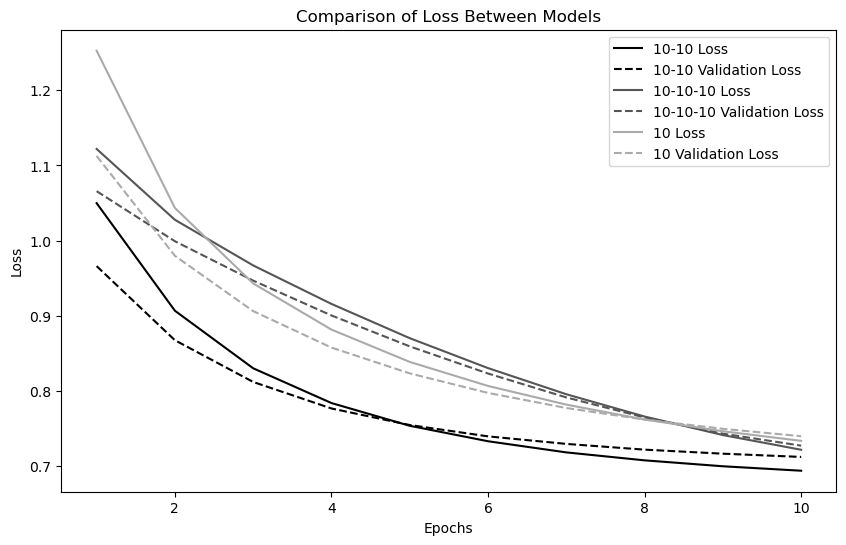

In [23]:
plot_multiple_histories({
    "10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10]
    })[2],
    "10-10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10, 10]
    })[2],
    "10-10-10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10, 10, 10]
    })[2],
  },
  show_validation=True
)

# Search Approches


## Grid Search

In [24]:


def get_name(params):
  return '-'.join([str(params[key]) for key in sorted(params.keys())])

def grid_search(param_grid, verbose=1, num_epochs=10):
  
  # params_list = []
  # acc_list = []
  # history_list = []
  history_dict = {}
  for params in sklearn.model_selection.ParameterGrid(param_grid):
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    
    # params_list.append(pars)
    # acc_list.append(acc)
    # history_list.append(history)
    history_dict[get_name(pars)] = history
  
  return history_dict

params: {'activation_function': 'elu', 'batch_size': 128, 'layer_sizes': [10]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3384 - loss: 1.2526 - val_accuracy: 0.3562 - val_loss: 1.1820
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3796 - loss: 1.1482 - val_accuracy: 0.3955 - val_loss: 1.1046
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4040 - loss: 1.0857 - val_accuracy: 0.4368 - val_loss: 1.0475
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4380 - loss: 1.0229 - val_accuracy: 0.4741 - val_loss: 1.0035
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4855 - loss: 0.9825 - val_accuracy: 0.5139 - val_loss: 0.9687
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5416 - loss: 0.9403 - val_accuracy: 0.5507 - val_loss: 0.9399
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5772 - loss: 0.9222 - val_accuracy: 0.5796 - val_loss: 0.9158
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0

DEBUG:__main__:sorted_keys: ['elu-128-[10, 10]-SGD', 'elu-128-[10]-SGD', 'elu-128-[10, 10, 10]-SGD', 'relu-128-[10, 10, 10]-SGD', 'relu-128-[10, 10]-SGD', 'relu-128-[10]-SGD']
DEBUG:__main__:accuracies: [1.0091248527169228, 1.019666537642479, 1.0222129672765732, 1.042184829711914, 1.0559738129377365, 1.0719256401062012]


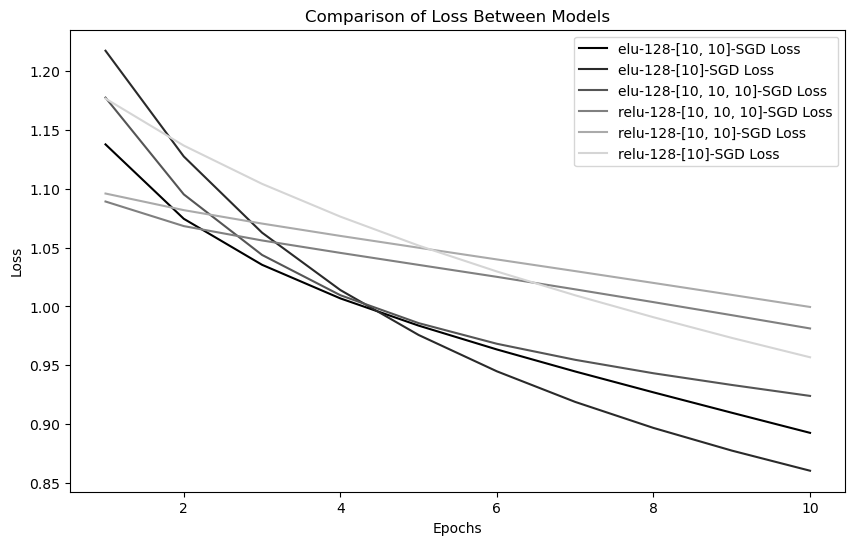

In [25]:
history_dict = grid_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[10], [10, 10], [10,10,10]],
    "batch_size" : [128]
  },
  # num_epochs=100
)
plot_multiple_histories(history_dict)

## Random Search

In [26]:
def random_search(param_grid, num_tests=5, random_state=None, verbose=1, num_epochs=10):
  
  # create a list of unique parameter combinations
  param_combs = list(sklearn.model_selection.ParameterGrid(param_grid))
  if len(param_combs) < num_tests:
    num_tests = len(param_combs)
  random_combs = np.random.choice(param_combs, size=num_tests,
    replace=False)
  
  # evaluate each of the combinations
  history_dict = {}
  for params in random_combs:
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    
    history_dict[get_name(pars)] = history
  
  return history_dict


params: {'activation_function': 'relu', 'batch_size': 128, 'layer_sizes': [10]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3474 - loss: 1.1412 - val_accuracy: 0.3562 - val_loss: 1.1237
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3761 - loss: 1.1109 - val_accuracy: 0.3836 - val_loss: 1.0954
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4190 - loss: 1.0839 - val_accuracy: 0.4169 - val_loss: 1.0719
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4374 - loss: 1.0614 - val_accuracy: 0.4542 - val_loss: 1.0516
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4713 - loss: 1.0351 - val_accuracy: 0.4796 - val_loss: 1.0337
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5016 - loss: 1.0235 - val_accuracy: 0.5050 - val_loss: 1.0176
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5286 - loss: 1.0038 - val_accuracy: 0.5294 - val_loss: 1.0028
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 

DEBUG:__main__:sorted_keys: ['elu-128-[10, 10, 10]-SGD', 'elu-128-[10, 10]-SGD', 'relu-128-[10]-SGD', 'relu-128-[10, 10]-SGD', 'relu-128-[10, 10, 10]-SGD']
DEBUG:__main__:accuracies: [0.956578254699707, 1.0422140061855316, 1.0505527555942535, 1.058003157377243, 1.0637927502393723]


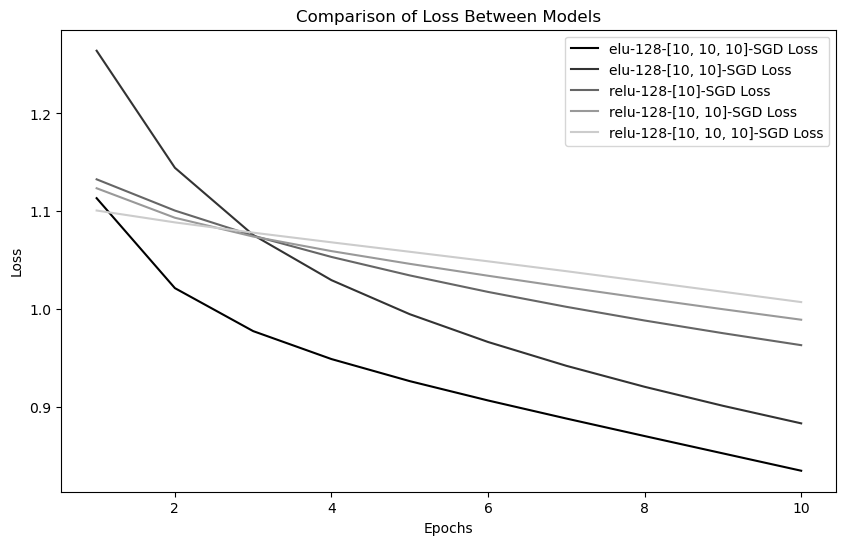

In [27]:
 history_dict = random_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[10], [10, 10], [10,10,10]],
    "batch_size" : [128]
  }
)
plot_multiple_histories(history_dict, sort_key="accuracy")

params: {'activation_function': 'elu', 'batch_size': 128, 'layer_sizes': [4, 4]}
Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3182 - loss: 1.3350 - val_accuracy: 0.3458 - val_loss: 1.2698
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3479 - loss: 1.2343 - val_accuracy: 0.3687 - val_loss: 1.1967
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3791 - loss: 1.1648 - val_accuracy: 0.3881 - val_loss: 1.1470
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3849 - loss: 1.1376 - val_accuracy: 0.4040 - val_loss: 1.1109
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4139 - loss: 1.0981 - val_accuracy: 0.4259 - val_loss: 1.0832
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4202 - loss: 1.0797 - val_accuracy: 0.4463 - val_loss: 1.0611
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4343 - loss: 1.0608 - val_accuracy: 0.4627 - val_loss: 1.0428
Epoch 8/200
37/37 ━━━━━━━━━━━

DEBUG:__main__:sorted_keys: ['elu-128-[2, 2]-SGD', 'elu-128-[4, 4]-SGD', 'elu-128-[2]-SGD', 'relu-128-[]-SGD', 'elu-128-[]-SGD', 'relu-128-[4]-SGD', 'relu-128-[4, 4, 4]-SGD', 'elu-128-[1]-SGD', 'relu-128-[1, 1, 1]-SGD']
DEBUG:__main__:accuracies: [0.6939527004054098, 0.7075900896029039, 0.7207198447049267, 0.7282170885139041, 0.7314488306792095, 0.7316825164086891, 0.77944160651679, 0.9043890523790109, 1.0986110510364655]


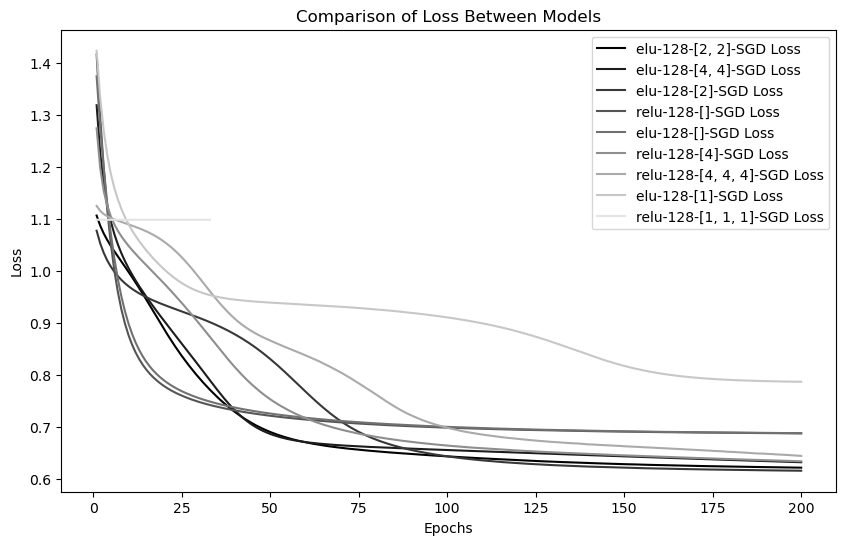

In [30]:
history_dict = random_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[2**layer_size] * num_layers for layer_size in range(0,5) for num_layers in range(0,4)],
    "batch_size" : [128]
  },
  num_epochs=200,
  num_tests=10
)

plot_multiple_histories(history_dict)

## Grid Search with logger

In [29]:
def grid_search(param_grid, verbose=1):
  
  set_logger(os.path.join(log_dir, tuning_log_file))
  tuning_logger = TuningLogger(pickle_file_name, test_size, name=test_name)
  
  params_list = []
  acc_list = []
  for params in ParameterGrid(param_grid):
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose)
    
    # log the trial results
    if log_results:
      tuning_logger.log_trial(pars, acc)
    
    params_list.append(pars)
    acc_list.append(acc)
  
  return params_list, acc_list
